# Improving Training-Free Neural Architecture Search using NRPA and NTK

In this notebook, we design several experiments aimed at evaluating two innovative NAS methods:

- A more efficient **search algorithm**, NRPA, that leverages Monte-Carlo playouts
- A more robust **training-free metric** based on the NTK

We conduct these experiments on the following NAS benchmark datasets:
- NAS-Bench-101
- NAS-Bench-201
- NAS-Bench-301
- NATS-Bench Size

## Imports

### Importing basic libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import json
from utils.helpers import configure_seaborn, normalize
import importlib
configure_seaborn()
from scipy.stats import spearmanr
import os

In [1]:
from nasbench import api  # NB101
from nas_201_api import NASBench201API as API  # NB201
import nasbench301 as nb  # NB301
import nats_bench  # NATS

Instructions for updating:
non-resource variables are not supported in the long term


### Importing our libraries

In [29]:
# NAS-Bench-101
from search_spaces.nas_bench_101.NASBench101Node import *
from search_spaces.nas_bench_101.NASBench101MCTS import *
from search_spaces.nas_bench_101.NASBench101RandomSearch import *
from search_spaces.nas_bench_101.NASBench101RegEvo import *

# NAS-Bench-201
from search_spaces.nas_bench_201.NASBench201Node import *
from search_spaces.nas_bench_201.NASBench201MCTS import *
from search_spaces.nas_bench_201.NASBench201RandomSearch import *
from search_spaces.nas_bench_201.NASBench201RegEvo import *

# NAS-Bench-301
from search_spaces.nas_bench_301.NASBench301Node import *
from search_spaces.nas_bench_301.NASBench301MCTS import *
from search_spaces.nas_bench_301.NASBench301RandomSearch import *
from search_spaces.nas_bench_301.NASBench301RegEvo import *

# NATS-Bench
from search_spaces.nats_bench_dataset.NATSBenchNode import *
from search_spaces.nats_bench_dataset.NATSBenchMCTS import *
from search_spaces.nats_bench_dataset.NATSBenchRandomSearch import *
from search_spaces.nats_bench_dataset.NATSBenchRegEvo import *

## Evaluating the search algorithms

Creating a dictionary of datasets for evaluation. This cell can take time to run.

In [4]:
models_1_0_dir = "API/nb_models"
model_paths = {
    model_name: os.path.join(models_1_0_dir, '{}_v1.0'.format(model_name))
    for model_name in ['xgb', 'lgb_runtime']
}
NB_301_performance_model = nb.load_ensemble(model_paths['xgb'])

print('Loading NB201')
nas_bench_201_api = API('api/NAS-Bench-201-v1_1-096897.pth', verbose=False)
print('Loading NB101')
nas_bench_101_api = api.NASBench("api/nasbench_full.tfrecord")
print('Loading NATS')
nats_bench_api = nats_bench.create("API/NATS-sss-v1_0-50262.pickle.pbz2", "sss", verbose=False)

/Users/samy/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:50:13] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Loading NB201
Loading NB101
Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 181 seconds
Loading NATS


In [8]:
datasets = {
            "nas_bench_101": {"api": nas_bench_101_api,
                              "n_runs": 100,
                              "n_iter": 3375,
                              "nrpa_level": 3,
                              "nrpa_alpha": .01},
            "nas_bench_201": {"api": nas_bench_201_api,
                              "n_runs": 100,
                              "n_iter": 2000,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}, 
            "nas_bench_301": {"api": NB_301_performance_model,
                              "n_runs": 100,
                              "n_iter": 10000,
                              "nrpa_level": 3,
                              "nrpa_alpha": 1},
            "nats_bench"   : {"api": nats_bench_api,
                              "n_runs": 100,
                              "n_iter": 4000,
                              "nrpa_level": 3,
                              "nrpa_alpha": .1}
            }

### NAS-Bench-101

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []}

params = datasets["nas_bench_101"]

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNASBench101(api=params["api"],
                                 max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNB101(api=params["api"],
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NASBench101Node.NASBench101Node(state=NASBench101Cell(n_vertices=7))
    uct = NASBench101UCT(root_node_uct,
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(12*uct.playouts_per_selection)
    
    root_node_nrpa = NASBench101NestedNode(state=NASBench101Cell(n_vertices=7), sequence=[])
    nrpa = NASBench101NRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    try:
        rs.run()
        re.run()
        _, _, _ = uct.main_loop()
        _, _, _ = nrpa.main_loop()
    
        
        methods["Random search"].append(rs.best_accs[1:])
        methods["Regularized evolution"].append(re.best_accs[1:])
        methods["UCT"].append(uct.best_reward)
        methods["NRPA"].append(nrpa.best_reward)
        
    except Exception: pass

    if not os.path.isdir('runs'):
        os.mkdir('runs')
        
    with open("runs/NASBench101.json", "w+") as f:
        json.dump(methods, f)

In [8]:
ma = max([len(e) for e in methods["UCT"]])
methods["UCT"] = [np.pad(e, (0,ma-len(e)), mode='maximum') for e in methods["UCT"]]

In [9]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.003) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

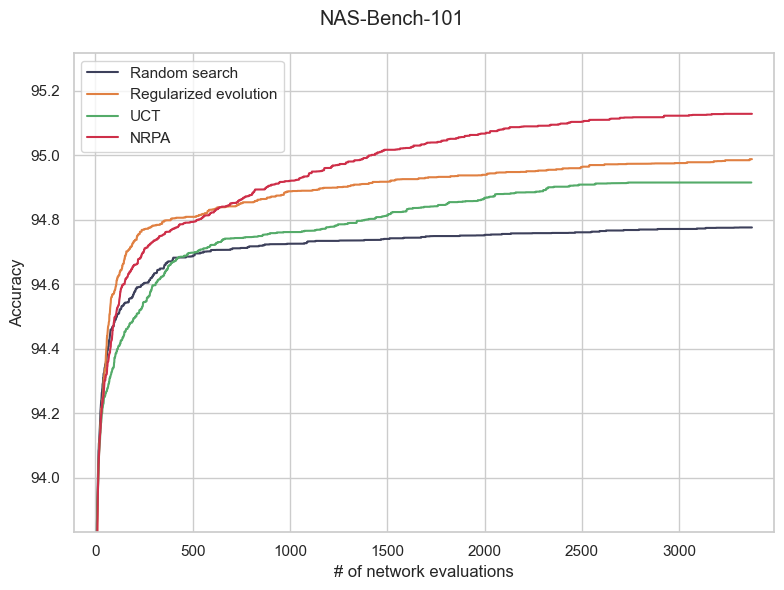

In [10]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_101"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_101"]["n_iter"]/30, datasets["nas_bench_101"]["n_iter"]+(datasets["nas_bench_101"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-101")
ax.legend()
plt.tight_layout()
plt.savefig("figures/NASBench-101.png")

### NATS-Bench

In [11]:
nats_bench_df = pd.read_csv("benchmark_scores/Cifar10-NATS.csv")

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []}

params = datasets["nats_bench"]
params["nrpa_alpha"] = 1
params["nrpa_level"] = 3

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNats(api=params["api"],
                          df=nats_bench_df,
                          max_iter=params["n_iter"])
    
    re = RegularizedEvolutionNATS(api=params["api"],
                                  df=nats_bench_df,
                                  population_size=50,
                                  cycles=params["n_iter"],
                                  sample_size=25)
    
    root_node_uct = NATSBenchSizeNode()
    uct = NATSBenchUCT(root_node_uct,
                       api=params["api"],
                       df=nats_bench_df,
                       params_path="utils/params.json",
                       disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(5*uct.playouts_per_selection)
    
    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)

In [13]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) / 10

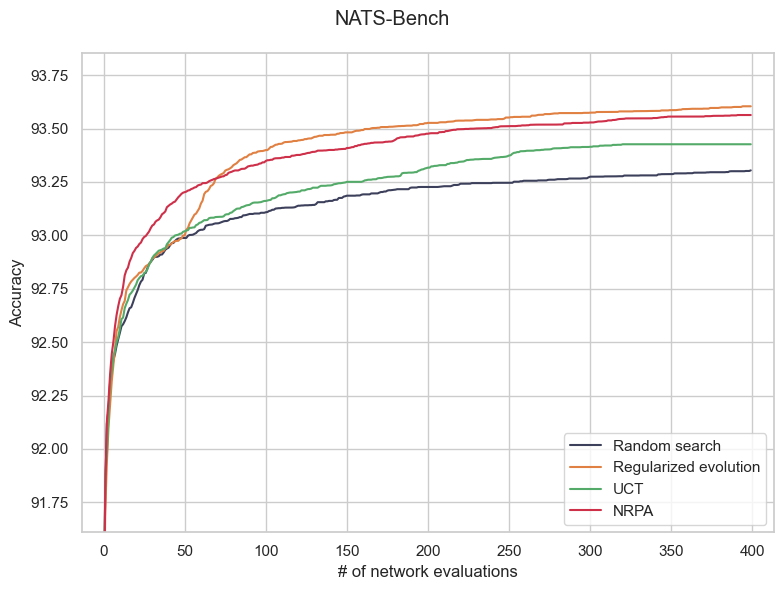

In [14]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nats_bench"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nats_bench"]["n_iter"]/30, datasets["nats_bench"]["n_iter"]+(datasets["nats_bench"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NATS-Bench")
ax.legend()
plt.tight_layout()
ax.legend()
if not os.path.isdir('figures'):
    os.mkdir("figures")
plt.savefig("figures/NATSBench.png")

### NAS-Bench-201

In [15]:
nas_bench_201_df = pd.read_csv("benchmark_scores/Cifar10-NB201.csv")

In [ ]:
methods = {"Random search": [], 
           "Regularized evolution": [], 
           "UCT": [],
           "NRPA": []}

params = datasets["nas_bench_201"]
params["n_iter"] = 100


for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB201(api=params["api"],
                           df=nas_bench_201_df,
                           max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB201(api=params["api"],
                                    df=nas_bench_201_df,
                                    population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = NASBench201Node(state=NASBench201Cell(4))
    uct = NASBench201UCT(root_node_uct,
                         api=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False,
                         df=nas_bench_201_df)
    uct.n_iter = params["n_iter"]//(6*uct.playouts_per_selection)
    
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)


In [17]:
max_value = max([np.max(e) for e in methods.values()])*100
min_value = min(np.quantile(e, 0.005) for e in methods.values())*100
ymax = (11*max_value - min_value) / 10

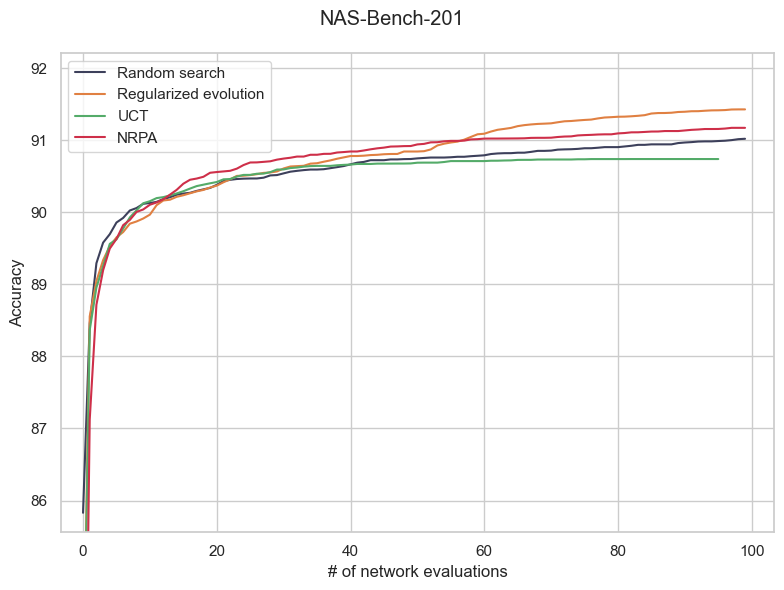

In [18]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]]*100, label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-201")
ax.legend()
plt.tight_layout()
ax.legend()
if not os.path.isdir('figures'):
    os.mkdir("figures")
plt.savefig("figures/NAS-Bench-201.png")

### NAS-Bench-301

In [5]:
from search_spaces.nas_bench_301.NASBench301RandomSearch import *
from search_spaces.nas_bench_301.NASBench301RegEvo import *

In [ ]:
methods = {
           "Random search": [], 
           "Regularized evolution": [], 
           "UCT": [], 
           "NRPA": []
           }

params = datasets["nas_bench_301"]

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    rs = RandomSearchNB301(max_iter=params["n_iter"])
    
    re =  RegularizedEvolutionNB301(population_size=50,
                                    cycles=params["n_iter"],
                                    sample_size=25)
    
    root_node_uct = DARTSNode((DARTSCell(), DARTSCell()))
    uct = NASBench301UCT(root_node_uct,
                         performance_model=params["api"],
                         params_path="utils/params.json",
                         disable_tqdm=False)
    uct.n_iter = params["n_iter"]//(16*uct.playouts_per_selection)
    
    
    root_node_nrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nrpa = NASBench301NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    rs.run()
    re.run()
    _, _, _ = uct.main_loop()
    _, _, _ = nrpa.main_loop()

    
    methods["Random search"].append(rs.best_accs[1:])
    methods["Regularized evolution"].append(re.best_accs[1:])
    methods["UCT"].append(uct.best_reward)
    methods["NRPA"].append(nrpa.best_reward)


In [9]:
max_value = max([np.max(e) for e in methods.values()])
min_value = min(np.quantile(e, 0.005) for e in methods.values())
ymax = (11*max_value - min_value) /10

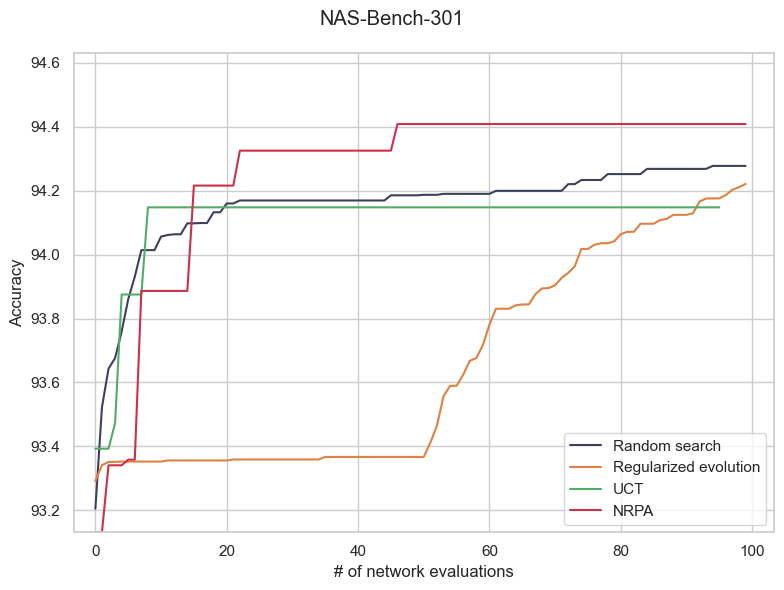

In [11]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_301"]["n_iter"]], label=name)
plt.ylim([min_value, ymax]); plt.xlim(-datasets["nas_bench_301"]["n_iter"]/30, datasets["nas_bench_301"]["n_iter"]+(datasets["nas_bench_301"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-301")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig("figures/NAS-Bench-301.png")

## MONET : Combining **Mo**nte-Carlo with **Ne**ural **T**angent Kernel

### On NAS-Bench-201

In [6]:
nas_bench_201_df = pd.read_csv("benchmark_scores/Cifar10-NB201.csv")

In [ ]:
params = datasets["nas_bench_201"]
accs_ntk_nb201 = []
ntks_ntk_nb201 = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk_nb201.append(nrpa.accuracies_tracker)
    ntks_ntk_nb201.append(nrpa.best_reward)

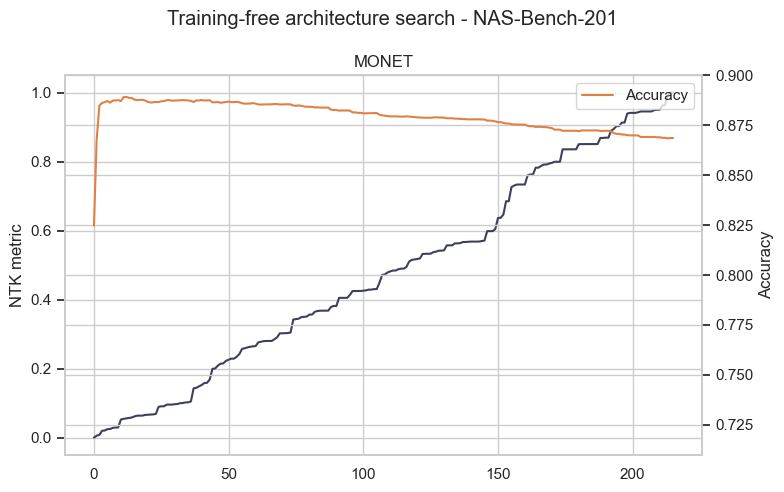

In [48]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(normalize(np.mean(np.array(ntks_ntk_nb201), axis=0)), label="NTK metric", color=sns.color_palette()[0])
ax.set_ylabel("NTK metric")

ax = ax.twinx()
ax.plot(np.mean(np.array(accs_ntk_nb201), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax.set_ylabel('Training-free metric'); ax.set_ylabel('Accuracy')
ax.set_title('MONET')

ax.set_xlabel('# of network evaluations')
ax.set_ylim([0.71, 0.9])
ax.legend()
f.suptitle('Training-free architecture search - NAS-Bench-201')
plt.tight_layout()
plt.show()

### On NATS-Bench

In [32]:
nats_bench_df = pd.read_csv("benchmark_scores/Cifar10-NATS.csv")

In [33]:
datasets["nats_bench"]["n_runs"]  = 100

In [ ]:
params = datasets["nats_bench"]
accs_ntk= []
ntks_ntk = []
for i in range(params["n_runs"]):
    print(f"Run {i+1} / {params['n_runs']}")

    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    nrpa.softmax_temp=2
    nrpa.metric = "score"
    a, b, c = nrpa.main_loop()
    accs_ntk.append(nrpa.accuracies_tracker)
    ntks_ntk.append(nrpa.best_reward)

Text(0.5, 0.98, 'Training-free architecture search - NATS')

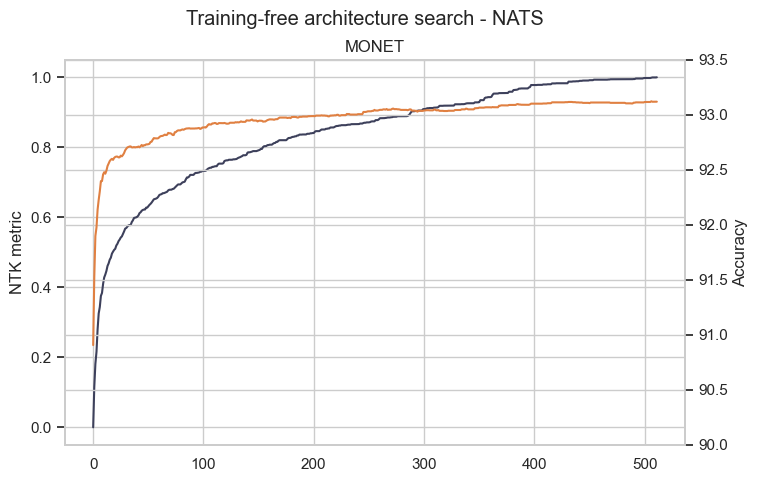

In [49]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(normalize(np.mean(np.array(ntks_ntk), axis=0)), label="NTK metric", color=sns.color_palette()[0])
ax.set_ylabel("NTK metric")

ax = ax.twinx()
ax.plot(np.mean(np.array(accs_ntk), axis=0), label="Accuracy", color=sns.color_palette()[1])
ax.set_ylabel('Training-free metric'); ax.set_ylabel('Accuracy')
ax.set_title('MONET')

ax.set_xlabel('# of network evaluations')
ax.set_ylim([90, 93.5])
f.suptitle('Training-free architecture search - NATS')

## NRPA vs Permutation NRPA

### On NAS-Bench-201

In [29]:
class NoPermutation201NRPA(NASBench201NRPA):

    def __init__(self, root_node: NASBench201NestedNode, level, api, save_folder=None, params_path=None,
                 disable_tqdm=False, df=None):
        super().__init__(root_node, level, api, save_folder, params_path,
                 disable_tqdm, df)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [ ]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nas_bench_201"]
params["n_runs"] = 10
params["n_iter"] = 1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nrpa = NASBench201NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = NASBench201NestedNode(state=NASBench201Cell(4), sequence=[])
    nonrpa = NoPermutation201NRPA(root_node_nonrpa,
                           params["nrpa_level"],
                           api=params["api"],
                           params_path="utils/params.json",
                           disable_tqdm=False, 
                           df=nas_bench_201_df)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)

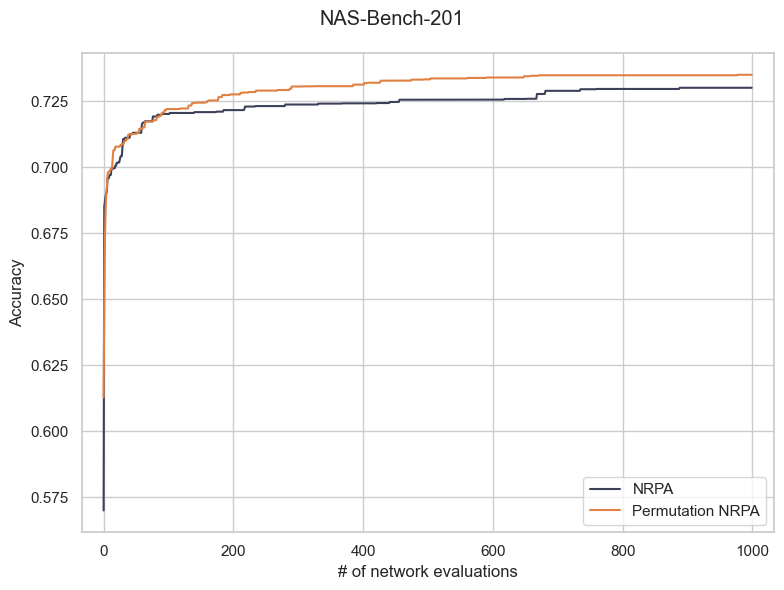

In [32]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]], label=name)
plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-201")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig('figures/nrpaVSpermunrpa-nb201.png')

### On NAS-Bench-301

In [ ]:
class NoPermutation301NRPA(NASBench301NRPA):

    def __init__(self, root_node: DARTSNestedNode, level, save_folder=None, params_path=None,
                 disable_tqdm=False):
        super().__init__(root_node, level, save_folder, params_path,
                 disable_tqdm)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [ ]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nas_bench_301"]
params["n_runs"]=5
params["n_iter"]=1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nrpa = NASBench301NRPA(root_node_nrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = DARTSNestedNode((DARTSCell(), DARTSCell()), sequence=[])
    nonrpa = NoPermutation301NRPA(root_node_nonrpa,
                           params["nrpa_level"],
                           params_path="utils/params.json",
                           disable_tqdm=False)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)
    

In [ ]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nas_bench_201"]["n_iter"]], label=name)
plt.xlim(-datasets["nas_bench_201"]["n_iter"]/30, datasets["nas_bench_201"]["n_iter"]+(datasets["nas_bench_201"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NAS-Bench-301")
ax.legend()
plt.tight_layout()
ax.legend()

### On NATS-Bench

In [33]:
class NoPermutationNATSNRPA(NATSBenchNRPA):

    def __init__(self, root_node: NATSBenchSizeNestedNode, level, api, save_folder=None, params_path=None,
                 disable_tqdm=False, df=None):
        super().__init__(root_node, level, api, save_folder, params_path,
                 disable_tqdm, df)

    def _code(self, node, move):

        if move == None:
            ### SEULEMENT POUR LA RACINE DE L'ARBRE A PRIORI
            return node.hash

        state_code = node.hash
        code = str(state_code) 
        for i in range(len(move)):
            code = code + str(move[i])

        return code

In [ ]:
methods = {"NRPA": [],
           "Permutation NRPA": []}

params = datasets["nats_bench"]
params["n_runs"] = 10
params["n_iter"] = 1000

for i in range(params["n_runs"]):
    print(f"RUN N° {i+1}/{params['n_runs']}")
    
    root_node_nrpa = NATSBenchSizeNestedNode(sequence=[])
    nrpa = NATSBenchNRPA(root_node_nrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nrpa.alpha = params["nrpa_alpha"]
    
    root_node_nonrpa = NATSBenchSizeNestedNode(sequence=[])
    nonrpa = NATSBenchNRPA(root_node_nonrpa,
                         params["nrpa_level"],
                         api=params["api"],
                         df=nats_bench_df,
                         params_path="utils/params.json",
                         disable_tqdm=False)
    nonrpa.n_iter = int(np.ceil(np.power(params["n_iter"], 1/params["nrpa_level"])))
    nonrpa.alpha = params["nrpa_alpha"]
    
    
    _, _, _ = nrpa.main_loop()
    _, _, _ = nonrpa.main_loop()
    
    methods["NRPA"].append(nonrpa.best_reward)
    methods["Permutation NRPA"].append(nrpa.best_reward)
    

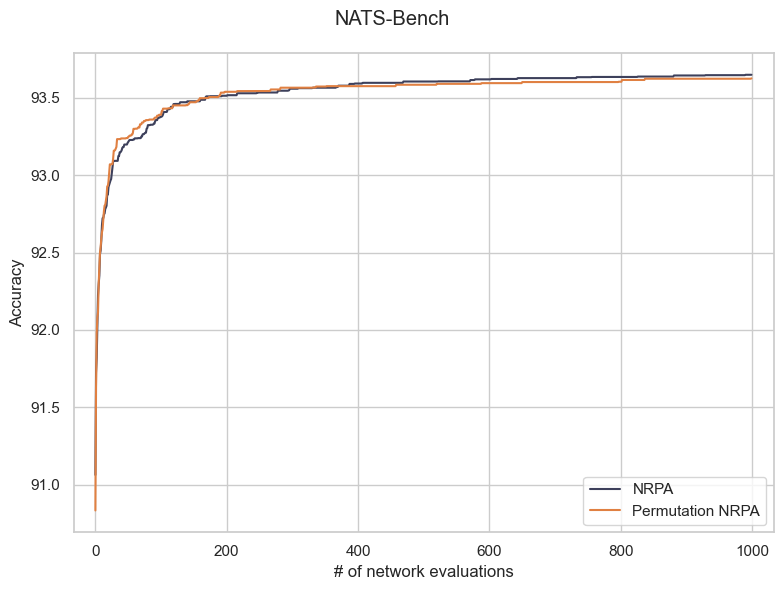

In [36]:
f, ax = plt.subplots(1,1,figsize=(8,6))
for name, results in methods.items():
    ax.plot(np.mean(results, axis=0)[:datasets["nats_bench"]["n_iter"]], label=name)
plt.xlim(-datasets["nats_bench"]["n_iter"]/30, datasets["nats_bench"]["n_iter"]+(datasets["nats_bench"]["n_iter"]/30))
ax.set_ylabel("Accuracy"); ax.set_xlabel("# of network evaluations")
f.suptitle("NATS-Bench")
ax.legend()
plt.tight_layout()
ax.legend()
plt.savefig('figures/nrpaVSpermunrpa-nats.png')